# 전국 공영 장례 조례 전처리 및 vectorDB 적재

### easyOCR

In [9]:
import easyocr
import numpy as np
from pdf2image import convert_from_path


reader = easyocr.Reader(['ko', 'en'], gpu=True) 

pages = convert_from_path('../data/processed/ordinance_book/공영_서울인천경기_지원내용_복잡.pdf', dpi = 300)

if pages:
    image_np = np.array(pages[0])
    
result = reader.readtext(image_np)


In [21]:
result

[([[np.int32(963), np.int32(318)],
   [np.int32(1523), np.int32(318)],
   [np.int32(1523), np.int32(367)],
   [np.int32(963), np.int32(367)]],
  '(현행  제정) 2024.01.03. 제1671호',
  np.float64(0.5596805693267364)),
 ([[np.int32(910), np.int32(411)],
   [np.int32(1551), np.int32(411)],
   [np.int32(1551), np.int32(509)],
   [np.int32(910), np.int32(509)]],
  '서울특별시 성동구',
  np.float64(0.9752326989345133)),
 ([[np.int32(576), np.int32(522)],
   [np.int32(807), np.int32(522)],
   [np.int32(807), np.int32(615)],
   [np.int32(576), np.int32(615)]],
  '무연고',
  np.float64(0.8854432106018066)),
 ([[np.int32(834), np.int32(522)],
   [np.int32(1070), np.int32(522)],
   [np.int32(1070), np.int32(615)],
   [np.int32(834), np.int32(615)]],
  '사망자',
  np.float64(0.9996965544713919)),
 ([[np.int32(1095), np.int32(522)],
   [np.int32(1895), np.int32(522)],
   [np.int32(1895), np.int32(615)],
   [np.int32(1095), np.int32(615)]],
  '등 공영장례 지원 조례',
  np.float64(0.7609539398360067)),
 ([[np.int32(321), np.int3

In [ ]:
# 1 페이지(인덱스0)  323, 490
# 4 페이지          321, 487

In [25]:
(323 + 490) / 2 , (321 + 487) / 2

(406.5, 404.0)

In [23]:
270 * 1.5, 274 * 1.5

(405.0, 411.0)

In [33]:
image_np = np.array(pages[3])
result = reader.readtext(image_np)

height, width, _ = image_np.shape

ocr_data_list = []
start_trigger = False

for (bbox, text, prob) in result:
    (tl, tr, br, bl) = bbox
    center_x = (tl[0] + tr[0]) / 2 # 다음 이프문을 위해 중복 계산
    if text == "지원내용" and 268 * 1.5 <= center_x <= 274 * 1.5:
        start_trigger = True

    if not start_trigger:
        continue
    
    if text in ["권한의 위임", "장사시설", "지원신청 및 결정"] :
        break
    
    x1, x2 = int(tl[0]), int(tr[0])
    y1, y2 = int(tl[1]), int(bl[1])
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    
    ocr_data_list.append({
        "text": text,
        "x1": x1, "x2": x2,
        "y1": y1, "y2": y2,
        "cx": center_x, 
        "cy": center_y,
        "used": False  # 사용자님 요청대로 사용 여부 체크
    })


ocr_data_list

[{'text': '지원내용',
  'x1': 321,
  'x2': 487,
  'y1': 1299,
  'y2': 1359,
  'cx': 404,
  'cy': 1329,
  'used': False},
 {'text': '1. 군수가 공영장례흘 위하여 지원할 수 잇는 내용은 다음과 같다',
  'x1': 316,
  'x2': 1511,
  'y1': 1380,
  'y2': 1437,
  'cx': 913,
  'cy': 1408,
  'used': False},
 {'text': '} {',
  'x1': 1287,
  'x2': 1366,
  'y1': 1498,
  'y2': 1591,
  'cx': 1326,
  'cy': 1544,
  'used': False},
 {'text': '시신 운반비,',
  'x1': 412,
  'x2': 618,
  'y1': 1681,
  'y2': 1731,
  'cx': 515,
  'cy': 1706,
  'used': False},
 {'text': '반소 설치, 제사상',
  'x1': 1087,
  'x2': 1382,
  'y1': 1703,
  'y2': 1753,
  'cx': 1234,
  'cy': 1728,
  'used': False},
 {'text': '영안실 안치료',
  'x1': 396,
  'x2': 631,
  'y1': 1736,
  'y2': 1791,
  'cx': 513,
  'cy': 1763,
  'used': False},
 {'text': '안치, 염습 , 입관,',
  'x1': 733,
  'x2': 1012,
  'y1': 1761,
  'y2': 1810,
  'cx': 872,
  'cy': 1785,
  'used': False},
 {'text': '차림  조문, 헌화',
  'x1': 1098,
  'x2': 1371,
  'y1': 1761,
  'y2': 1810,
  'cx': 1234,
  'cy': 1785,
  'used': Fals

In [34]:
lines_list = []

pre_data = None
line_num = 1
region_num = 1
ocr_data_list = ocr_data_list[1:].copy()
DPI_MUL = 1.5
# 200 DPI 기준 설정 후 400DPI 적용 시 2배 적용
MIN_COLUMN_GAP = 35 * DPI_MUL     # 띄어쓰기보다 훨씬 크면 컬럼 구분으로 생각하려고, 보통은 200DPI에서 10 ~ 15정도가 띄어쓰기임
LINE_GAP = 20 * DPI_MUL           # 줄 간격, 한 줄 내에서 많이 차이나면 10정도라서 그 두 배
CENTER_X_GAP = 5 * DPI_MUL        # text식별 박스의 x중앙값이 같은 컬럼이면 가운데 정렬이라 별 차이 안 나길래 일단 5 설정.
SOME_INT = 400 * DPI_MUL          # 이 값보다 크면 2번째 이상의 컬럼 text라고 판단할 임의의 값 지정

for idx, ocr_data in enumerate(ocr_data_list):
    # 이전 데이터 없으면 리스트에 딕셔너리 추가.
    if pre_data is None:
        lines_list.append({f'line{line_num}' : [ocr_data]})
        ocr_data['used'] = True
        pre_data = ocr_data
        continue

    # 리스트에 텍스트가 이미 들어갔다면 진행 안 함.
    if ocr_data['used'] == True:
        pre_data = ocr_data
        continue

    # 줄 바뀌지 않고, 이전 단어와 간격 작을 때는 이전 단어의 라인에 추가 (위치적으로 높으면 숫자 낮음)
    if (abs(pre_data['y1'] - ocr_data['y1']) <= LINE_GAP) and (ocr_data['x1'] - pre_data['x2'] < MIN_COLUMN_GAP):
        last_dict = lines_list[-1]
        current_key = list(last_dict.keys())[0]
        last_dict[current_key].append(ocr_data)
        pre_data = ocr_data
        continue

    # 1번째 구역 글이 처음 발견
    if (idx + 1 < len(ocr_data_list)) and (abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP) and (ocr_data_list[idx+1]['x1'] - ocr_data['x2'] >= MIN_COLUMN_GAP):
        lines_list.append({f'region{region_num}' : [ocr_data]})
        ocr_data['used'] = True

        for data in ocr_data_list: 
            if not data['used'] and abs(data['cx'] - ocr_data['cx']) <= CENTER_X_GAP:
                lines_list[-1][f'region{region_num}'].append(data)
                data['used'] = True

        region_num += 1
        pre_data = ocr_data
        continue

    # 2번째, 3번째, (있다면 4번째) 구역 글
    if (ocr_data['x1'] - pre_data['x2'] >= MIN_COLUMN_GAP) or (abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP and ocr_data['x1'] > SOME_INT) :
        lines_list.append({f'region{region_num}' : [ocr_data]})
        ocr_data['used'] = True

        for data in ocr_data_list: 
            if not data['used'] and abs(data['cx'] - ocr_data['cx']) <= CENTER_X_GAP:
                lines_list[-1][f'region{region_num}'].append(data)
                data['used'] = True

        region_num += 1
        pre_data = ocr_data
        continue

    # 줄 바뀌면 다음 라인으로 생성
    if abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP:
        lines_list.append({f'line{line_num}' : [ocr_data]})
        line_num += 1
        ocr_data['used'] = True
        pre_data = ocr_data
        continue    


In [35]:
final_lines_list = [
    " ".join([item['text'] for item in list(line_dict.values())[0]]) 
    for line_dict in lines_list
]

# 결과 확인
for line in final_lines_list:
    print(line)

1. 군수가 공영장례흘 위하여 지원할 수 잇는 내용은 다음과 같다
} {
시신 운반비, 영안실 안치료 타 기관 지원으로 별도 비용 발생하지 않앉다면 지원 제외
반소 설치, 제사상 차림  조문, 헌화 등의 장례의식에 소요되는 비용
안치, 염습 , 입관, 운구 등의 비용
봉안비용 무연고 사망자 지원
화장비용
2 지원 한도는   r국민기초생활  보장법_  장제급여의 20096   범위에서 정하되, 필요시 예산의 범위에서
추가로 지원할 수 있다:


### 시각화 해보기 (with 제미나이)

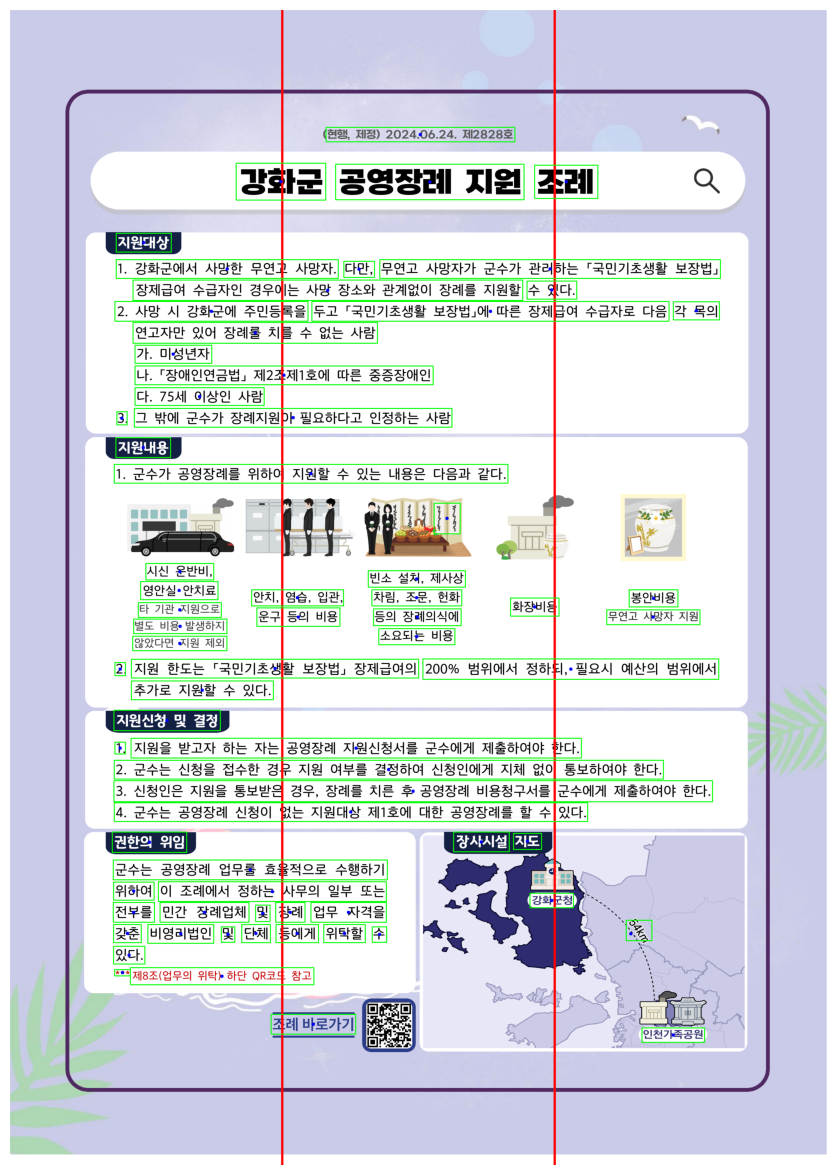

In [29]:
import matplotlib.pyplot as plt
import cv2

# 시각화를 위해 이미지 복사
debug_img = image_np.copy()
height, width, _ = debug_img.shape
threshold_1 = width / 3
threshold_2 = threshold_1 * 2
# 1. 내가 설정한 기준선(threshold) 그리기 (빨간선)
# 위에서 설정한 threshold_1, threshold_2 변수 사용
cv2.line(debug_img, (int(threshold_1), 0), (int(threshold_1), height), (255, 0, 0), 5) 
cv2.line(debug_img, (int(threshold_2), 0), (int(threshold_2), height), (255, 0, 0), 5)
# cv2.line(debug_img, (int(400), 0), (int(400), height), (255, 0, 0), 5)

# 2. OCR이 인식한 텍스트 박스 그리기 (초록박스)
for (bbox, text, prob) in result:
    (tl, tr, br, bl) = bbox
    
    # 박스 그리기
    pt1 = (int(tl[0]), int(tl[1]))
    pt2 = (int(br[0]), int(br[1]))
    cv2.rectangle(debug_img, pt1, pt2, (0, 255, 0), 2)
    
    # 텍스트 중심점 찍기 (파란점)
    center_x = int((tl[0] + tr[0]) / 2)
    center_y = int((tl[1] + bl[1]) / 2)
    cv2.circle(debug_img, (center_x, center_y), 5, (0, 0, 255), -1)

# 이미지 출력
plt.figure(figsize=(15, 15))
plt.imshow(debug_img)
plt.axis('off')
plt.show()

In [7]:
result

[([[np.int32(652), np.int32(212)],
   [np.int32(1016), np.int32(212)],
   [np.int32(1016), np.int32(244)],
   [np.int32(652), np.int32(244)]],
  '현행  제정) 2024.01.03. 제1671호',
  np.float64(0.4968716864801708)),
 ([[np.int32(608), np.int32(273)],
   [np.int32(863), np.int32(273)],
   [np.int32(863), np.int32(342)],
   [np.int32(608), np.int32(342)]],
  '서울특별시',
  np.float64(0.9824764632588374)),
 ([[np.int32(879), np.int32(276)],
   [np.int32(1035), np.int32(276)],
   [np.int32(1035), np.int32(338)],
   [np.int32(879), np.int32(338)]],
  '성동구',
  np.float64(0.999591875853089)),
 ([[np.int32(385), np.int32(347)],
   [np.int32(539), np.int32(347)],
   [np.int32(539), np.int32(411)],
   [np.int32(385), np.int32(411)]],
  '무연고',
  np.float64(0.8573444485664368)),
 ([[np.int32(557), np.int32(349)],
   [np.int32(713), np.int32(349)],
   [np.int32(713), np.int32(411)],
   [np.int32(557), np.int32(411)]],
  '사망자',
  np.float64(0.9931611411492176)),
 ([[np.int32(729), np.int32(349)],
   [np.int32

### clova OCR

In [23]:
from pdf2image import convert_from_path
import requests
import uuid
import json
import time
from PIL import Image
import io
import os
import numpy as np
from dotenv import load_dotenv
load_dotenv()


True

In [7]:
CLOVA_API_URL = os.getenv("CLOVA_API_URL");
CLOVA_SECRET_KEY = os.getenv("CLOVA_SECRET_KEY"); 

In [8]:
complex_pages = [19, 33, 35, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]
print(complex_pages)

[19, 33, 35, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]


In [ ]:
def images_to_text_with_ocr(images, api_url, secret_key, complex_pages):
    """
    PDF → 이미지 변환 → OCR → 텍스트
    
    Args:
        pdf_path: PDF 파일 경로
        api_url: 클로바 OCR API Gateway URL
        secret_key: 클로바 OCR Secret Key
    
    Returns:
        str: 추출된 전체 텍스트 (페이지별로 \n\n 구분)
    """
    # complex_pages
    
    # 전체 페이지의 텍스트를 저장할 리스트    
    all_text = []
    all_result = []
    
    # 2. 각 페이지마다 OCR
    for i, img in enumerate(images):
        if (i+1) not in complex_pages:  # 복잡 페이지 아니면 그냥 가져가고 맞으면 중간 끼워 넣는 작업 해야할 듯. 
            continue

        if i != 18:
            continue

        print(f"Processing page {i+1}...")
        
        # PIL Image 객체를 BytesIO (메모리 상의 바이너리)로 변환
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')    # PNG 형식으로 저장
        img_byte_arr.seek(0)    # 파일 포인터를 처음으로 되돌림
        
        # OCR API 요청 데이터 구성
        request_json = {
            'images': [{'format': 'png', 'name': f'page_{i+1}'}],   # 이미지 정보
            'requestId': str(uuid.uuid4()), # 고유 요청 ID (랜덤 생성)
            'version': 'V2',    # API 버전
            'timestamp': int(time.time() * 1000)    # 현재 시간 (밀리초)
        }
        
        # 요청 본문 (message)과 파일 데이터 준비
        payload = {'message': json.dumps(request_json).encode('UTF-8')}
        files = [('file', img_byte_arr)]    # 이미지 바이너리
        headers = {'X-OCR-SECRET': secret_key}  # 인증 헤더
        
        # OCR API 호출 (POST 요청)
        response = requests.post(api_url, headers=headers, data=payload, files=files)

        # 응답 성공 
        if response.status_code == 200:
            result = response.json()    # JSON 응답 파싱
            all_result.append(result)
            # 모든 필드의 inferText를 공백으로 연결
            # page_text = ' '.join([field['inferText'] 
            #                       for field in result['images'][0]['fields']])
            # all_text.append(page_text)  # 해당 페이지 텍스트 저장
        else:
            # 실패 시 에러 출력
            print(f"Page {i+1} failed: {response.status_code}")
            
    # 모든 페이지 텍스트를 \n\n로 구분하여 반환
    return all_result

In [ ]:
ordinance_book_path_1 = '../data/raw/ordinance_book/공영장례_조례집(서울_인천_경기).pdf'

images1 = convert_from_path(ordinance_book_path_1, dpi=300)


In [ ]:
if images1:
    image_np1 = np.array(images1[0])


In [ ]:
api_url = CLOVA_API_URL
secret_key = CLOVA_SECRET_KEY
complex_pages = [19, 33, 35, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]



results = images_to_text_with_ocr(images1, api_url, secret_key, complex_pages)    

Processing page 19...


In [29]:
dict2 = [{"name" : 'hello', 'byt' : 'byebye'}]
for dic in dict2:
    name, byt = dic.values()
    print(name, byt)


hello byebye


In [ ]:
result

[([[np.int32(963), np.int32(318)],
   [np.int32(1523), np.int32(318)],
   [np.int32(1523), np.int32(367)],
   [np.int32(963), np.int32(367)]],
  '(현행  제정) 2024.01.03. 제1671호',
  np.float64(0.5596805693267364)),
 ([[np.int32(910), np.int32(411)],
   [np.int32(1551), np.int32(411)],
   [np.int32(1551), np.int32(509)],
   [np.int32(910), np.int32(509)]],
  '서울특별시 성동구',
  np.float64(0.9752326989345133)),
 ([[np.int32(576), np.int32(522)],
   [np.int32(807), np.int32(522)],
   [np.int32(807), np.int32(615)],
   [np.int32(576), np.int32(615)]],
  '무연고',
  np.float64(0.8854432106018066)),
 ([[np.int32(834), np.int32(522)],
   [np.int32(1070), np.int32(522)],
   [np.int32(1070), np.int32(615)],
   [np.int32(834), np.int32(615)]],
  '사망자',
  np.float64(0.9996965544713919)),
 ([[np.int32(1095), np.int32(522)],
   [np.int32(1895), np.int32(522)],
   [np.int32(1895), np.int32(615)],
   [np.int32(1095), np.int32(615)]],
  '등 공영장례 지원 조례',
  np.float64(0.7609539398360067)),
 ([[np.int32(321), np.int3

### pdfplumber bounding box

In [15]:
results[0]['images'][0]['fields']

[{'valueType': 'ALL',
  'boundingPoly': {'vertices': [{'x': 959.0, 'y': 316.0},
    {'x': 1065.0, 'y': 316.0},
    {'x': 1065.0, 'y': 367.0},
    {'x': 959.0, 'y': 367.0}]},
  'inferText': '(현행,',
  'inferConfidence': 0.9989,
  'type': 'NORMAL',
  'lineBreak': False},
 {'valueType': 'ALL',
  'boundingPoly': {'vertices': [{'x': 1059.0, 'y': 316.0},
    {'x': 1153.0, 'y': 316.0},
    {'x': 1153.0, 'y': 363.0},
    {'x': 1059.0, 'y': 363.0}]},
  'inferText': '제정)',
  'inferConfidence': 0.9998,
  'type': 'NORMAL',
  'lineBreak': False},
 {'valueType': 'ALL',
  'boundingPoly': {'vertices': [{'x': 1150.0, 'y': 316.0},
    {'x': 1379.0, 'y': 316.0},
    {'x': 1379.0, 'y': 363.0},
    {'x': 1150.0, 'y': 363.0}]},
  'inferText': '2024.01.03.',
  'inferConfidence': 0.9954,
  'type': 'NORMAL',
  'lineBreak': False},
 {'valueType': 'ALL',
  'boundingPoly': {'vertices': [{'x': 1375.0, 'y': 316.0},
    {'x': 1526.0, 'y': 316.0},
    {'x': 1526.0, 'y': 363.0},
    {'x': 1375.0, 'y': 363.0}]},
  'infe

In [7]:
(329 + 486)/2,    268 * 1.5, 274 * 1.5

(407.5, 402.0, 411.0)

In [ ]:
ocr_data_list = []
start_trigger = False
# {'vertices': [{'x': 1375.0, 'y': 316.0},
#     {'x': 1526.0, 'y': 316.0},
#     {'x': 1526.0, 'y': 363.0},
#     {'x': 1375.0, 'y': 363.0}]}


# valueType, boundingPoly, inferText, inferConfidence, type, lineBreak
for dict in results[0]['images'][0]['fields']:
    (_, boundingPoly, inferText, inferConfidence, _,_) = dict.values()
    (tl, tr, br, bl) = boundingPoly['vertices']

    center_x = (tl['x'] + tr['x']) / 2 # 다음 이프문을 위해 중복 계산
    if text == "지원내용" and 402 <= center_x <= 411:
        start_trigger = True

    if not start_trigger:
        continue
    
    if text in ["권한의 위임", "장사시설", "지원신청 및 결정"] :
        break
    
    x1, x2 = int(tl['x']), int(tr['x'])
    y1, y2 = int(tl['y']), int(bl['y'])
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    
    ocr_data_list.append({
        "text": text,
        "x1": x1, "x2": x2,
        "y1": y1, "y2": y2,
        "cx": center_x, 
        "cy": center_y,
        "used": False  # 사용자님 요청대로 사용 여부 체크
    })


ocr_data_list

In [ ]:
lines_list = []

pre_data = None
line_num = 1
region_num = 1
ocr_data_list = ocr_data_list[1:].copy()


MIN_COLUMN_GAP = 35 * DPI_MUL     # 띄어쓰기보다 훨씬 크면 컬럼 구분으로 생각하려고, 보통은 200DPI에서 10 ~ 15정도가 띄어쓰기임
LINE_GAP = 20 * DPI_MUL           # 줄 간격, 한 줄 내에서 많이 차이나면 10정도라서 그 두 배
CENTER_X_GAP = 5 * DPI_MUL        # text식별 박스의 x중앙값이 같은 컬럼이면 가운데 정렬이라 별 차이 안 나길래 일단 5 설정.
SOME_INT = 400 * DPI_MUL          # 이 값보다 크면 2번째 이상의 컬럼 text라고 판단할 임의의 값 지정

for idx, ocr_data in enumerate(ocr_data_list):
    # 이전 데이터 없으면 리스트에 딕셔너리 추가.
    if pre_data is None:
        lines_list.append({f'line{line_num}' : [ocr_data]})
        ocr_data['used'] = True
        pre_data = ocr_data
        continue

    # 리스트에 텍스트가 이미 들어갔다면 진행 안 함.
    if ocr_data['used'] == True:
        pre_data = ocr_data
        continue

    # 줄 바뀌지 않고, 이전 단어와 간격 작을 때는 이전 단어의 라인에 추가 (위치적으로 높으면 숫자 낮음)
    if (abs(pre_data['y1'] - ocr_data['y1']) <= LINE_GAP) and (ocr_data['x1'] - pre_data['x2'] < MIN_COLUMN_GAP):
        last_dict = lines_list[-1]
        current_key = list(last_dict.keys())[0]
        last_dict[current_key].append(ocr_data)
        pre_data = ocr_data
        continue

    # 1번째 구역 글이 처음 발견
    if (idx + 1 < len(ocr_data_list)) and (abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP) and (ocr_data_list[idx+1]['x1'] - ocr_data['x2'] >= MIN_COLUMN_GAP):
        lines_list.append({f'region{region_num}' : [ocr_data]})
        ocr_data['used'] = True

        for data in ocr_data_list: 
            if not data['used'] and abs(data['cx'] - ocr_data['cx']) <= CENTER_X_GAP:
                lines_list[-1][f'region{region_num}'].append(data)
                data['used'] = True

        region_num += 1
        pre_data = ocr_data
        continue

    # 2번째, 3번째, (있다면 4번째) 구역 글
    if (ocr_data['x1'] - pre_data['x2'] >= MIN_COLUMN_GAP) or (abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP and ocr_data['x1'] > SOME_INT) :
        lines_list.append({f'region{region_num}' : [ocr_data]})
        ocr_data['used'] = True

        for data in ocr_data_list: 
            if not data['used'] and abs(data['cx'] - ocr_data['cx']) <= CENTER_X_GAP:
                lines_list[-1][f'region{region_num}'].append(data)
                data['used'] = True

        region_num += 1
        pre_data = ocr_data
        continue

    # 줄 바뀌면 다음 라인으로 생성
    if abs(pre_data['y1'] - ocr_data['y1']) > LINE_GAP:
        lines_list.append({f'line{line_num}' : [ocr_data]})
        line_num += 1
        ocr_data['used'] = True
        pre_data = ocr_data
        continue    


In [ ]:
final_lines_list = [
    " ".join([item['text'] for item in list(line_dict.values())[0]]) 
    for line_dict in lines_list
]

# 결과 확인
for line in final_lines_list:
    print(line)

### 클로바OCR 시각화

In [ ]:
import matplotlib.pyplot as plt
import cv2

# 시각화를 위해 이미지 복사
debug_img = image_np1.copy()
height, width, _ = debug_img.shape
threshold_1 = width / 3
threshold_2 = threshold_1 * 2
# 1. 내가 설정한 기준선(threshold) 그리기 (빨간선)
# 위에서 설정한 threshold_1, threshold_2 변수 사용
cv2.line(debug_img, (int(threshold_1), 0), (int(threshold_1), height), (255, 0, 0), 5) 
cv2.line(debug_img, (int(threshold_2), 0), (int(threshold_2), height), (255, 0, 0), 5)
# cv2.line(debug_img, (int(400), 0), (int(400), height), (255, 0, 0), 5)

# 2. OCR이 인식한 텍스트 박스 그리기 (초록박스)
for dict in results[0]['images'][0]['fields']:
    (_, boundingPoly, inferText, inferConfidence, _,_) = dict.values()
    (tl, tr, br, bl) = boundingPoly['vertices']
    
    # 박스 그리기
    pt1 = (int(tl['x']), int(tl['y']))
    pt2 = (int(br['x']), int(br['y']))
    cv2.rectangle(debug_img, pt1, pt2, (0, 255, 0), 2)
    
    # 텍스트 중심점 찍기 (파란점)
    center_x = int((tl['x'] + tr['x']) / 2)
    center_y = int((tl['y'] + bl['y']) / 2)
    cv2.circle(debug_img, (center_x, center_y), 5, (0, 0, 255), -1)

# 이미지 출력
plt.figure(figsize=(15, 15))
plt.imshow(debug_img)
plt.axis('off')
plt.show()